In [1]:
from src.optimization_model.lp_model import OliveHarvestModel, OliveHarvestModel_ServiceLevel
from src.optimization_model.model_data import OliveHarvestData, OliveHarvestDataFromJSON

In [2]:

# get_data weather 

# train the diffusion model to generate weather scenarios

# generate weather scenarios

# get mean and std for uncertain parameters 

json_path = "src/optimization_model/params_model.json"



In [3]:
data = OliveHarvestDataFromJSON(json_path=json_path, alpha=0.99)
mu = list(data.G.values()) 
sigma = [0.1 * mu_j for mu_j in mu]  # example: 10% std dev

In [4]:
len(data.J)

63

In [5]:
len(sigma)

63

In [6]:
len(mu)

63

In [7]:

model = OliveHarvestModel_ServiceLevel(data, sigma=sigma, mu=mu)
status = model.solve(msg=True)
print("Status:", status)
print("Objective (oil):", model.objective_value())
print("ReqBudget:", model.required_budget_value())
print("Nonzero x:", len(model.get_x()))
    

63
63
63
63
Status: Infeasible
Objective (oil): 980.3744910157457
ReqBudget: 23343.49886790082
Nonzero x: 17


In [8]:
import math

def norm_ppf(p: float) -> float:
    """
    Inverse CDF (quantile) for standard normal N(0,1).
    Acklam rational approximation. Good accuracy for (0,1).
    """
    if p <= 0.0 or p >= 1.0:
        raise ValueError("p must be in (0,1)")

    # Coefficients in rational approximations
    a = [-3.969683028665376e+01,  2.209460984245205e+02,
         -2.759285104469687e+02,  1.383577518672690e+02,
         -3.066479806614716e+01,  2.506628277459239e+00]

    b = [-5.447609879822406e+01,  1.615858368580409e+02,
         -1.556989798598866e+02,  6.680131188771972e+01,
         -1.328068155288572e+01]

    c = [-7.784894002430293e-03, -3.223964580411365e-01,
         -2.400758277161838e+00, -2.549732539343734e+00,
          4.374664141464968e+00,  2.938163982698783e+00]

    d = [ 7.784695709041462e-03,  3.224671290700398e-01,
          2.445134137142996e+00,  3.754408661907416e+00]

    plow = 0.02425
    phigh = 1 - plow

    if p < plow:
        q = math.sqrt(-2 * math.log(p))
        num = (((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5])
        den = ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
        return num / den

    if p > phigh:
        q = math.sqrt(-2 * math.log(1 - p))
        num = (((((c[0]*q + c[1])*q + c[2])*q + c[3])*q + c[4])*q + c[5])
        den = ((((d[0]*q + d[1])*q + d[2])*q + d[3])*q + 1)
        return -(num / den)

    q = p - 0.5
    r = q * q
    num = (((((a[0]*r + a[1])*r + a[2])*r + a[3])*r + a[4])*r + a[5]) * q
    den = (((((b[0]*r + b[1])*r + b[2])*r + b[3])*r + b[4])*r + 1)
    return num / den



In [9]:
@staticmethod
def z_value(alpha: float) -> float:
    return norm_ppf(alpha)

In [10]:
import matplotlib.pyplot as plt

def run_sweep_and_plot(
    json_path: str,
    sigma, 
    mu,
    alphas=(0.95, 0.975, 0.99),
    msg=False
):
    records = []  # list of dicts: alpha, oil, budget, status

    for a in alphas:
        data = OliveHarvestDataFromJSON(json_path=json_path, alpha=float(a))
        model = OliveHarvestModel_ServiceLevel(data, mu, sigma)

        status = model.solve(msg=msg)
        oil = model.objective_value()
        bud = model.required_budget_value()

        records.append({
            "alpha": float(a),
            "status": status,
            "oil": float(oil) if oil is not None else None,
            "budget": float(bud) if bud is not None else None,
        })

    # Filter feasible/optimal solves for plotting
    good = [r for r in records if r["oil"] is not None and r["budget"] is not None]

    if not good:
        print("No feasible solutions to plot. Statuses:")
        for r in records:
            print(r["alpha"], r["status"])
        return records

    al = [r["alpha"] for r in good]
    oil = [r["oil"] for r in good]
    bud = [r["budget"] for r in good]

    # --- Plot 1: Oil vs Confidence ---
    plt.figure()
    plt.plot(al, oil, marker="o")
    plt.xlabel("Confidence level (alpha)")
    plt.ylabel("Objective: oil yield")
    plt.title("Oil yield vs confidence level")
    plt.grid(True)
    plt.show()

    # --- Plot 2: Budget vs Confidence ---
    plt.figure()
    plt.plot(al, bud, marker="o")
    plt.xlabel("Confidence level (alpha)")
    plt.ylabel("Required budget")
    plt.title("Required budget vs confidence level")
    plt.grid(True)
    plt.show()

    # --- Plot 3: Oil vs Budget (trade-off) ---
    plt.figure()
    plt.scatter(bud, oil)
    plt.xlabel("Required budget")
    plt.ylabel("Objective: oil yield")
    plt.title("Trade-off: oil yield vs required budget")

    # label each point with alpha
    for r in good:
        plt.annotate(
            f'{r["alpha"]:.3f}',
            (r["budget"], r["oil"]),
            textcoords="offset points",
            xytext=(6, 6),
            ha="left"
        )

    plt.grid(True)
    plt.show()

    # Print summary table
    print("alpha | status | oil | budget")
    for r in records:
        print(f'{r["alpha"]:.3f} | {r["status"]} | {r["oil"]} | {r["budget"]}')

    return records

63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63


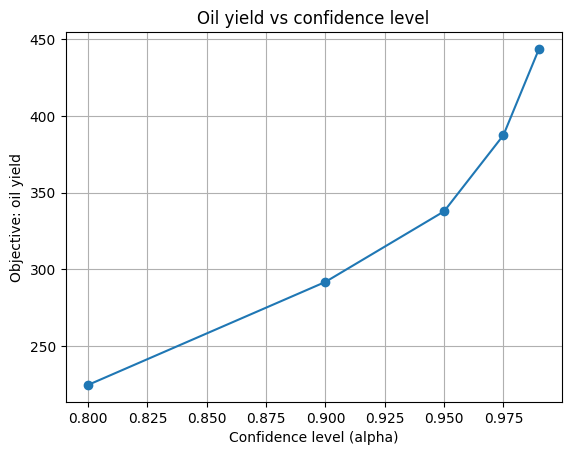

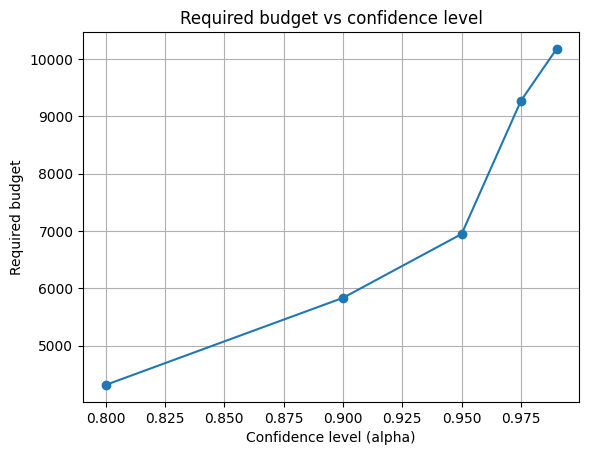

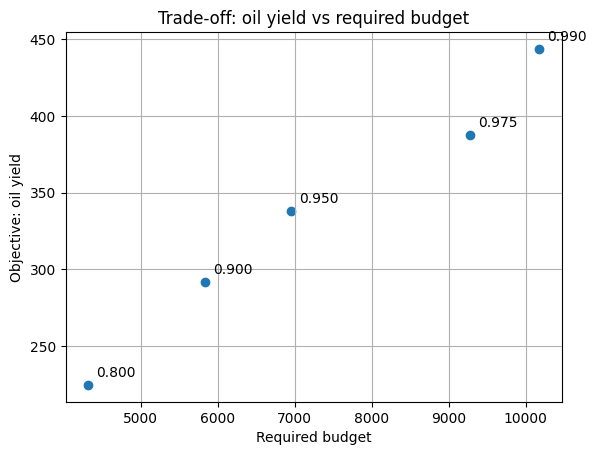

alpha | status | oil | budget
0.800 | Infeasible | 224.46121897137536 | 4315.424657145237
0.900 | Infeasible | 291.6923711529738 | 5833.6536064084
0.950 | Infeasible | 337.75902546689883 | 6947.59057315123
0.975 | Infeasible | 387.46803448703565 | 9271.625238073068
0.990 | Infeasible | 443.80136949277005 | 10173.588713473115


In [11]:
records = run_sweep_and_plot(json_path, sigma, mu, alphas=[0.80, 0.90, 0.95, 0.975, 0.99], msg=False)